# Exercise: Extracting Light Curves using Different Masks

## Goal

When working with NASA Kepler, K2 and TESS data, the assumptions we make when we build the aperture can drastically effect our light curve. In this exercise we will investigate how changing the aperture can impact the signal to noise of a transit detection. We will use the *Pi Mensae* light curve from TESS sector 1.

### Building different apertures with lightkurve

When we have a target of interest, we can build a set of apertures with different sizes and test the CDPP in each. First, use lightkurve to download the *Pi Mensae* target pixel file from sector 1.

In [1]:
import lightkurve as lk
search = lk.search_targetpixelfile("Pi Mensae", sector=1)
tpf = search.download()

Next we will build three different aperture masks of different sizes. Use lightkurve to create three **threshold masks** with different sizes, and plot them.

**Hint: ** The `tpf.create_threshold_mask(threshold=...)` method allows you to create a pixel aperture mask containing all the pixels which are `threshold * sigma` brighter than the median background.

In [8]:
apers = []
# Loop through three different threshold values to build three masks
for idx, threshold in enumerate([1, 10, 100]):
    # Append them to a list
    apers.append(tpf.create_threshold_mask(threshold=threshold))

In [11]:
# Each aperture should be a boolean mask
apers[0]

array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False,  True,  True,  True,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False],
       [ True,  True,  True,  True,  True,  True,  True,  Tr

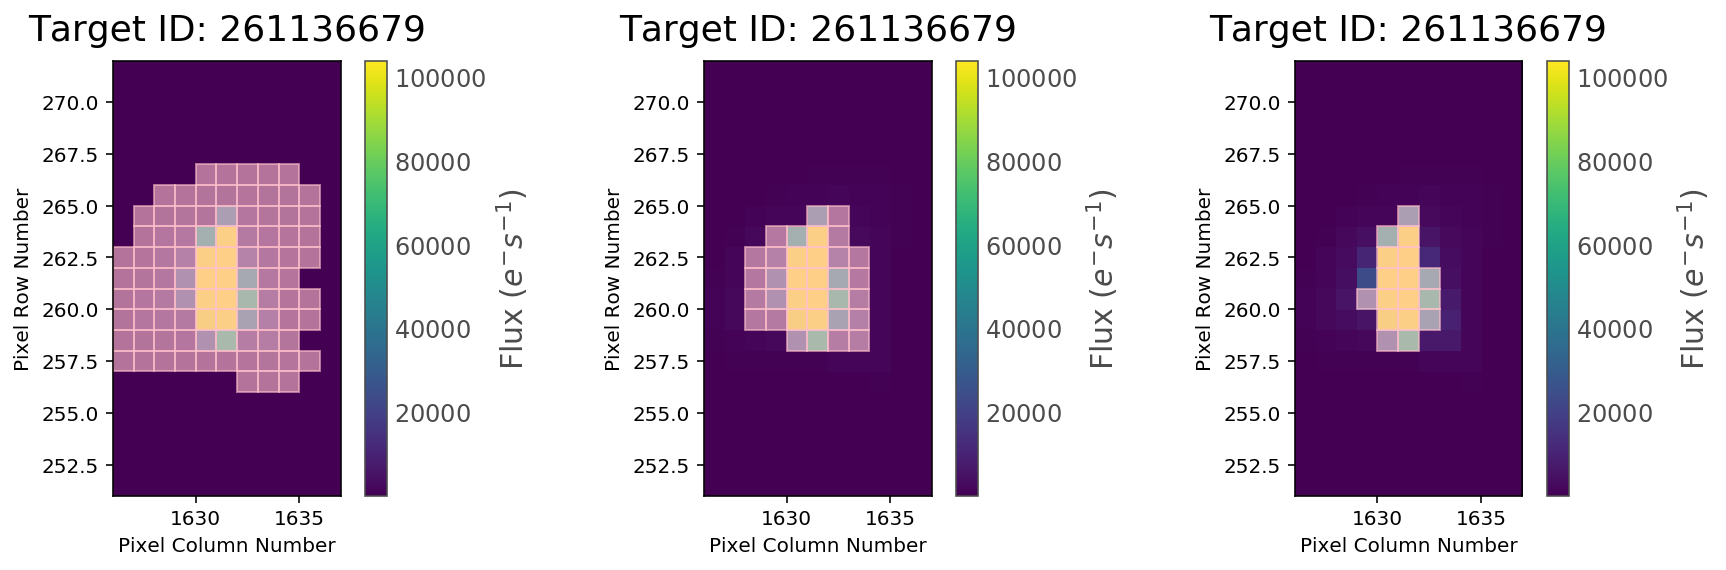

In [7]:
# Using matplotlib.pyplot's subplots method we can create a plot that has three panels 
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Loop through the aperture masks
for idx, aper in enumerate(apers):
    # Use lightkurve to plot each tpf with each mask.
    tpf.plot(ax=axs[idx], aperture_mask=aper)

### Building different light curves, using new apertures

Now that we have three different apertures, we can use them to build light curves. Use the `tpf.to_lightcurve()` method to create three new light curves, and plot them on the same panel to compare them. 

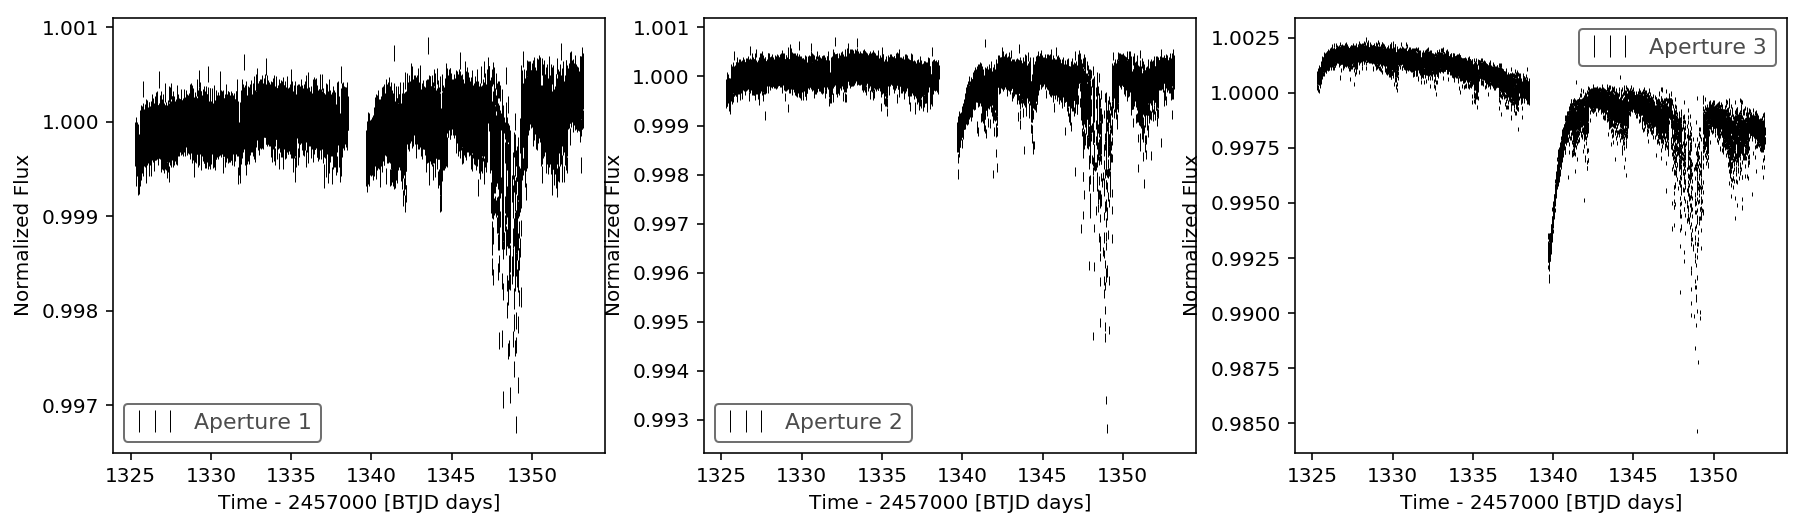

In [21]:
# Another three panel plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Loop over each aperture
for idx, aper in enumerate(apers):
    # Build a light curve using the tpf.to_lightcurve() method
    lc = tpf.to_lightcurve(aperture_mask=aper)
    # Plot the lightcurve
    lc.errorbar(ax=axs[idx], c='k', label='Aperture {}'.format(idx + 1))

Once you have built light curves, try flattening and folding each light curve on to show the folded transit of *Pi 
Mensae c*

**Hint: ** The period and transit midpoint of *Pi Mensae c* is:
* period = 6.27
* t0 = 1325.504 

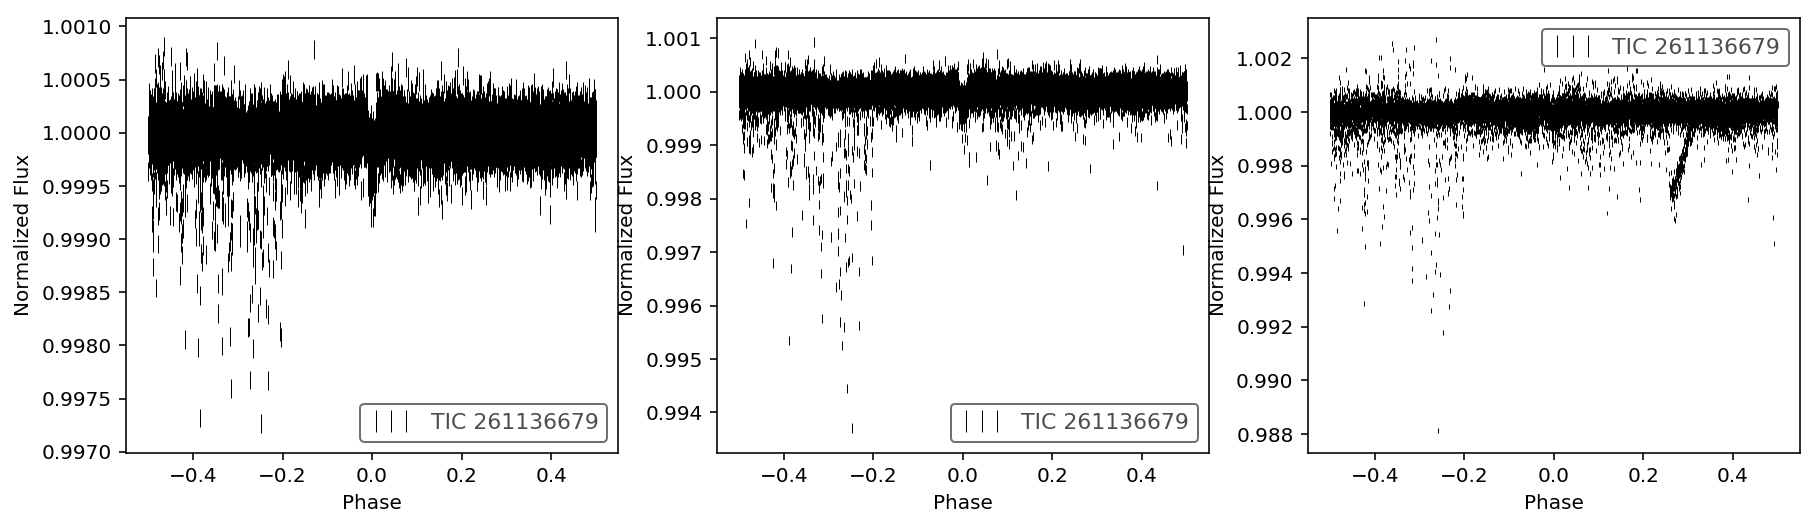

In [23]:
period = 6.27
t0 = 1325.504

# Another three panel plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Loop over each aperture
for idx, aper in enumerate(apers):
    lc = tpf.to_lightcurve(aperture_mask=aper)
    flat = lc.flatten(window_length=1001)
    folded = flat.fold(period, t0)
    folded.errorbar(ax=axs[idx], c='k')

The folded light curve will have a transit at the center. However, the transit has ashort duration, compared with the period. Use indexing to cut down the folded light curve to contain only points between $-0.1$ and $0.1$ in phase.

**Hint:** You can index light curves in the same way you index `numpy` arrays. e.g.
```Python
lc[30:-10].plot()
lc[100].flux
boolean_mask = [ False, False, True, True ...]
lc[boolean_mask].time
```

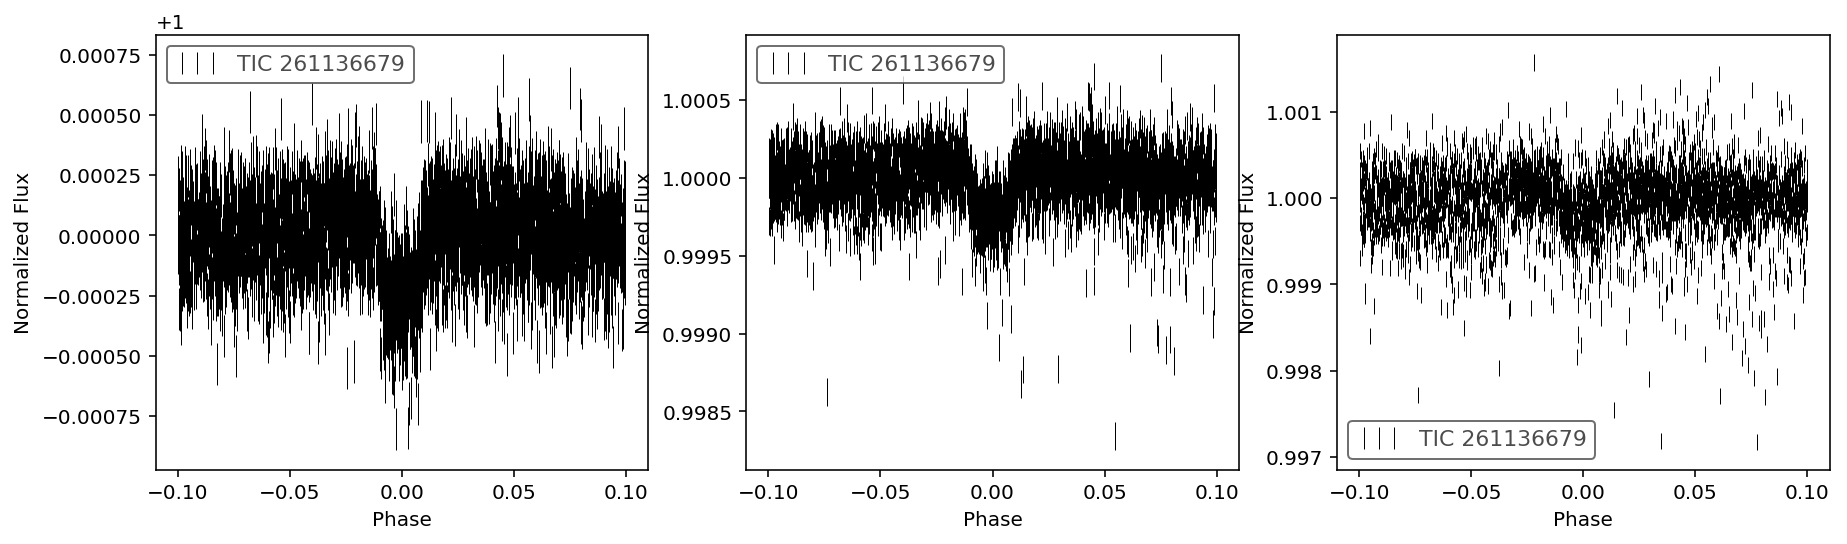

In [24]:
period = 6.27
t0 = 1325.504

# Another three panel plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Loop over each aperture
for idx, aper in enumerate(apers):
    lc = tpf.to_lightcurve(aperture_mask=aper)
    flat = lc.flatten(window_length=1001)
    folded = flat.fold(period, t0)
    mask = (folded.time > -0.1) & (folded.time < 0.1)
    folded[mask].errorbar(ax=axs[idx], c='k')

### Finding the optimum aperture

Now we have light curves, we can use the `estimate_cdpp` method to identify which aperture has the best signal to noise. Loop over each of your light curves and identify which mask gives the best CDPP. (Note that lower CDPP values indicate a less noisy light curve.) 

**Hint:** You can read more about the CDPP metric in the `estimate_cdpp()` method doc string.

In [28]:
cdpp = []

# Loop over each aperture
for aper in apers:
    lc = tpf.to_lightcurve(aperture_mask=aper)
    cdpp.append(lc.estimate_cdpp())

In [32]:
import numpy as np
best_aper = np.argmin(cdpp)

Use the best aperture you have created to create a light curve, and compare it with the light curve from the TESS pipeline. Plot the two **folded** light curves (your own aperture and the PDCSAP light curve from the pipeline) in the same panel, using light curve.

**Hint**: You can access light curve data using the `search_lightcurvefile` function in lightkurve.

In [43]:
lcf = lk.search_lightcurvefile("Pi Mensae", sector=1).download()

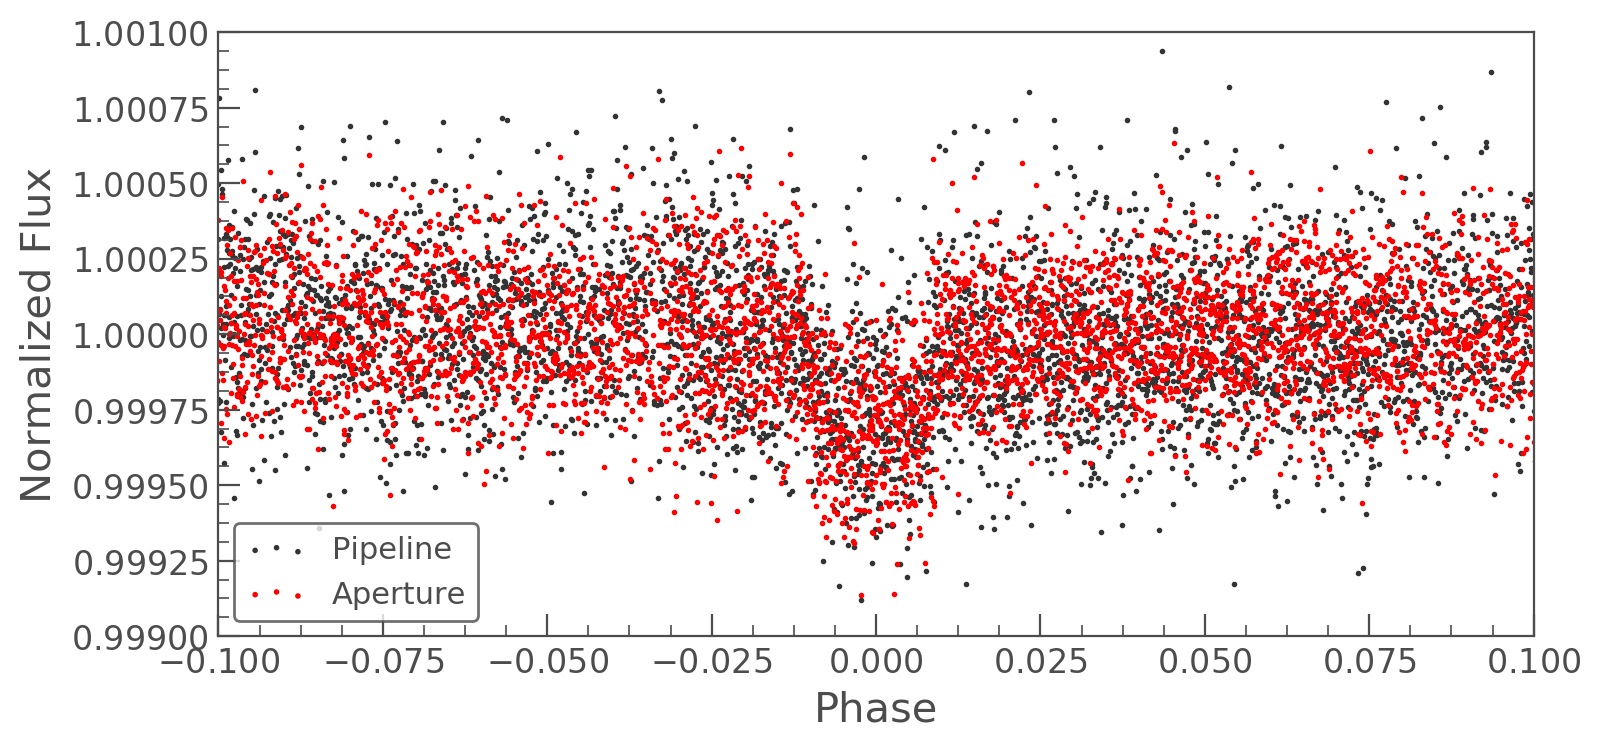

In [44]:
pipeline_lc = lcf.PDCSAP_FLUX
ax = pipeline_lc.fold(period, t0).scatter(label='Pipeline')

lc = tpf.to_lightcurve(aperture_mask=apers[best_aper])
lc.fold(period, t0).scatter(ax=ax, c='r', label='Aperture')

ax.set_xlim([-0.1, +0.1])
ax.set_ylim([0.999, 1.001]);

Plot the two light curves, using the lightkurve `bin()` method to reduce the time resolution and increase the signal to noise of the transit. If you have carefully selected your aperture, you should be able to achieve a signal to noise in the transit equal to or higher than the pipeline!

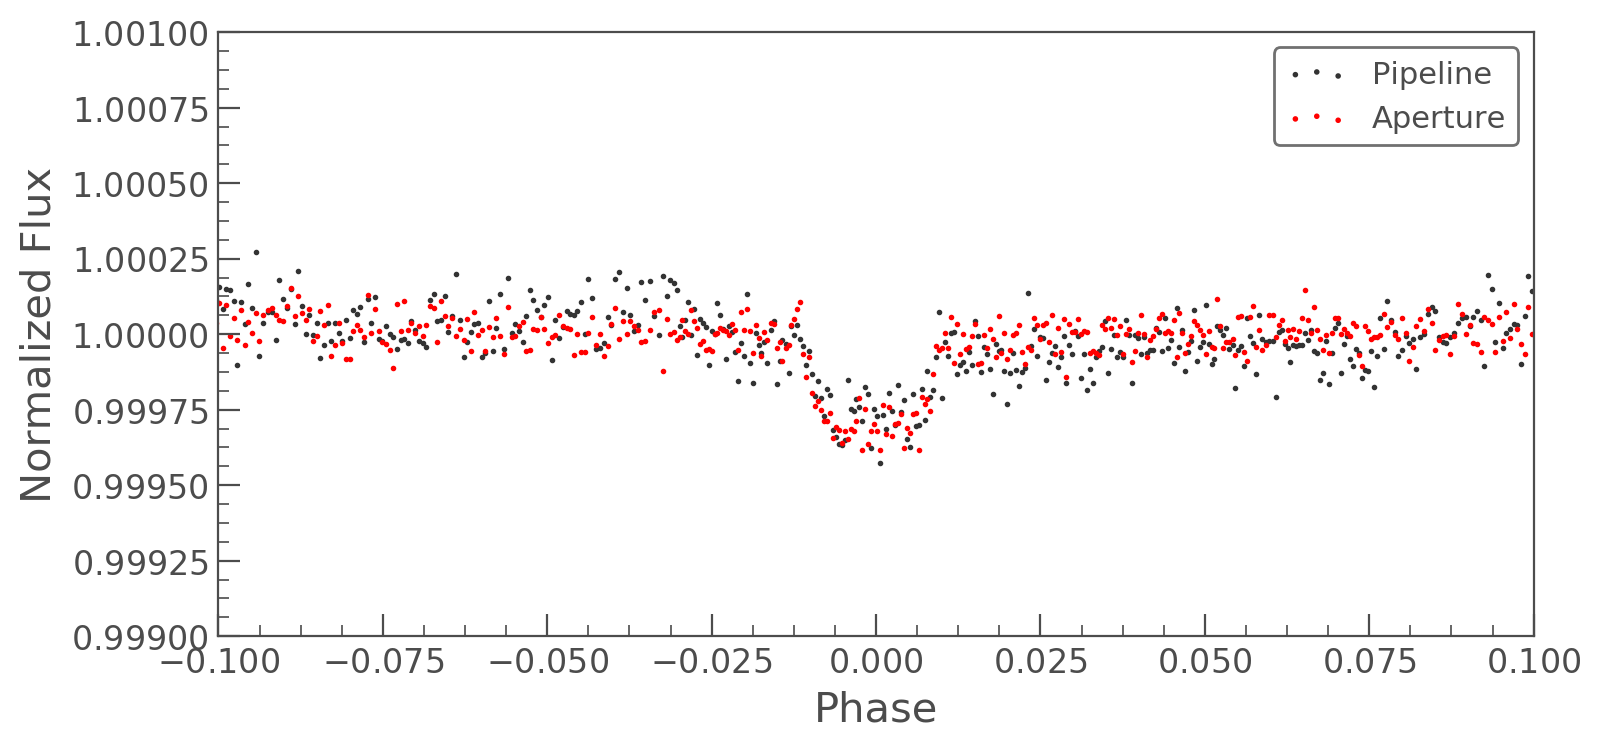

In [46]:
pipeline_lc = lcf.PDCSAP_FLUX
ax = pipeline_lc.fold(period, t0).bin(10).scatter(label='Pipeline')

lc = tpf.to_lightcurve(aperture_mask=apers[best_aper])
lc.fold(period, t0).bin(10).scatter(ax=ax, c='r', label='Aperture')

ax.set_xlim([-0.1, +0.1])
ax.set_ylim([0.999, 1.001]);